# HySwash: A hybrid method for nearshore wave processes

![sketch](./assets/hyswash-sketch.png)

If you want to run this notebook using the pickle files exported in Part 1, execute the code below. Otherwise, you can skip it.

In [ ]:
import requests
import tarfile
import os

url = "https://geoocean.sci.unican.es/data/HyVeggy_exported.tar.gz.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=os.getcwd())

In [17]:
import os
import os.path as op
import numpy as np
import utils.plotting
import bluemath_tk.topo_bathy.profiles
from bluemath_tk.datamining.lhs import LHS
from bluemath_tk.datamining.mda import MDA
from bluemath_tk.waves.series import waves_dispersion 
from bluemath_tk.wrappers.swash.swash_wrapper import HySwashVeggyModelWrapper
from bluemath_tk.core.io import load_model
from bluemath_tk.core.plotting.scatter import plot_scatters_in_triangle
import xarray as xr
import matplotlib.pyplot as plt
from utils.plotting import animate_case_propagation
from IPython.display import HTML
import utils.ChySwash

root_dir = os.getcwd()
#output_dir = "/lustre/geocean/DATA/hidronas1/valva/Veggy"
output_dir = os.path.join(root_dir, "output")
templates_dir = os.path.join(root_dir, "templates", "HyVeggy")
export_dir = op.join(root_dir, "HyVeggy_exported")

Load swash_model and mda from a pickle file and postprocessed_output NetCDF file

In [9]:
mda=load_model(op.join(export_dir, "mda_model.pkl"))
swash_model=load_model(op.join(export_dir, "swash_model.pkl"))
depth_file=op.join(templates_dir,"depth.bot")
depth_array = np.loadtxt(depth_file)
postprocessed_output = xr.open_dataset(op.join(export_dir, "output_postprocessed_clean.nc"))

## 5. Reconstruction: Principal Component Analysis (PCA) & Radial Basis Fucntions (RBF)

The reconstruction of the time series of wave parameters in the position of the buoy is carried out by an interpolation technique based on radial basis functions (RBF), a scheme wich is very convenient for scatter and multivariate data. The RBF approximation has been applied successfully in many fields, usually with better results than other interpolation methods (Hardy, 1990).
    
Suppose that $f=f(x)$ is the real-valued function that we want to approximate. We are given M scattered data points $\{x_1,..., x_M\}$ of dimension $\textit{n}$ and the associated real function values $\{f_1, ..., f_M\}$, being $f_i = f(x_j), j = 1,...,M$. The RBF interpolation method consists of a weighted sum of radially symmetric basic functions located at the data points. The approximation function is assumed to be of the form:
$$RBF(x) = p(x) + \sum\limits_{j=1}^M a_j\Phi{\large (}{\large \parallel}{x - x_j}{\large \parallel}{\large )}$$

### Hs reconstruction

In [ ]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.interpolation.rbf import RBF

postprocessed_output=postprocessed_output.copy(deep=True)

# Apply PCA to the postprocessed output
pca = PCA()
_pcs_ds = pca.fit_transform(
    data=postprocessed_output,
    vars_to_stack=["Hs"],
    coords_to_stack=["Xp"],
    pca_dim_for_rows="case_num",
    value_to_replace_nans={"Hs": 0.0},
)

# Apply RBF reconstruction
rbf = RBF()
rbf.fit(
    subset_data=mda.centroids.iloc[postprocessed_output["case_num"].values, :],
    target_data=pca.pcs_df,
)

pca.save_model(
    model_path=op.join(export_dir, "pca_model.pkl"),
)
rbf.save_model(
    model_path=op.join(export_dir, "rbf_model.pkl"),
)


        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.98
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        

        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-05-28 18:22:25,905 - PCA - WARNING - Attribute pcs is an xarray Dataset / Dataarray and will be pickled!


In [71]:
pca=load_model(op.join(export_dir, "pca_model.pkl"))
rbf=load_model(op.join(export_dir, "rbf_model.pkl"))

Visualize the effect of the plants on Hs

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import show_graph_for_different_parameters
variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "Wv","hv","Nv"]
lhs_parameters = {
    "num_dimensions": 5,
    "num_samples": 11000,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.5, 0.003, 0, 0, 0],
    "upper_bounds": [3, 0.01, 200, 1.5, 1000],
}
utils.plotting.show_graph_for_different_parameters(pca=pca, rbf=rbf,lhs_parameters=lhs_parameters,depthfile=depth_file)

interactive(children=(FloatSlider(value=2.462939903482534, description='Hs', max=3.0, min=0.5, step=0.25), Flo…

<function utils.plotting.show_graph_for_different_parameters.<locals>.update_plot(Hs, Hs_L0, Wv, hv, Nv)>

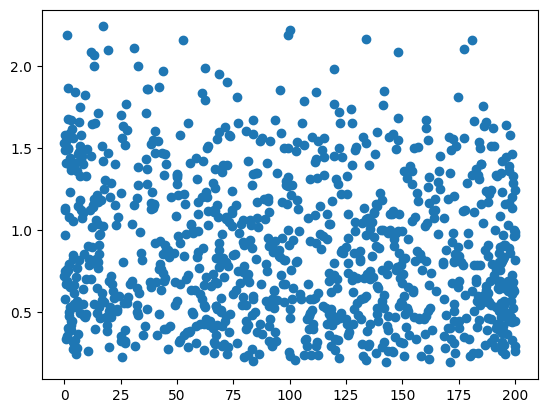

In [80]:
plt.scatter(mda.centroids.loc[postprocessed_output["case_num"].values, :]["Wv"],postprocessed_output["Ru2"].values)

### Ru2 reconstruction

In [ ]:
# Fit the RBF model to the postprocessed output
from bluemath_tk.interpolation.rbf import RBF
rbf_Ru = RBF()
rbf_Ru.fit(
    subset_data=mda.centroids.iloc[postprocessed_output["case_num"].values, :],
    target_data=pd.DataFrame(postprocessed_output["Ru2"].values, columns=["Ru2"])
)
rbf_Ru.save_model(
    model_path=op.join(export_dir, "rbf_Ru_model.pkl"),
)

INFO:RBF:Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
INFO:RBF:Checking for NaNs in subset data
INFO:RBF:Preprocessing subset data
INFO:RBF:Normalizing subset data
INFO:RBF:Subset data preprocessed successfully
INFO:RBF:Checking for NaNs in target data
INFO:RBF:Preprocessing target data
INFO:RBF:Normalizing target data
INFO:RBF:Target data preprocessed successfully
INFO:RBF:Fitting RBF model to the data
INFO:RBF:Fitting RBF for variable Ru2



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


INFO:RBF:Optimal sigma: 0.1773331430409503 - Time: 219.75 seconds


In [63]:
lhs_dataset

,Wv,hv,Nv,Hs,Hs_L0
0,147.795271,0.600149,711.711681,2.5,0.005
1,171.620540,0.617065,39.153347,2.5,0.005
2,86.068919,0.247772,456.900813,2.5,0.005
3,179.588976,0.984739,918.923713,2.5,0.005
4,91.068107,0.276635,75.393610,2.5,0.005
...,...,...,...,...,...
495,35.214145,0.431263,631.727669,2.5,0.005
496,170.102108,0.993969,33.106959,2.5,0.005
497,34.940957,1.113168,502.316178,2.5,0.005
498,180.172712,0.435274,266.174177,2.5,0.005


In [83]:
Hs=2.5
Hs_Lo=0.005


rbf_Ru=load_model(op.join(export_dir, "rbf_Ru_model.pkl"))
variables_to_analyse_in_metamodel = ["Wv","hv","Nv"]
lhs_parameters = {
    "num_dimensions": 3,
    "num_samples": 500,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0, 0, 0],
    "upper_bounds": [200, 1.5, 1000],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"),
)

lhs_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

# Add Hs and Hs_Lo to the lhs dataset
lhs_dataset["Hs"] = Hs
lhs_dataset["Hs_L0"] = Hs_Lo
# lhs_dataset["hv"]=1
# lhs_dataset["Nv"]=1000
# Predict the PCA components using the RBF model

Ru_dataset=rbf_Ru.predict(lhs_dataset)

#fig,axes=plot_scatters_in_triangle(dataframes=[df_lhs_data,df_centroids],s=1,data_colors=["blue","red"])

INFO:RBF:Reconstructing data using fitted coefficients.
INFO:RBF:Checking for NaNs in subset data
INFO:RBF:Preprocessing subset data
INFO:RBF:Normalizing subset data
INFO:RBF:Subset data preprocessed successfully
INFO:RBF:Interpolating target variable Ru2
INFO:RBF:Denormalizing target data


In [75]:
lhs_dataset

,Wv,hv,Nv,Hs,Hs_L0
0,147.795271,1,1000,2.5,0.005
1,171.620540,1,1000,2.5,0.005
2,86.068919,1,1000,2.5,0.005
3,179.588976,1,1000,2.5,0.005
4,91.068107,1,1000,2.5,0.005
...,...,...,...,...,...
495,35.214145,1,1000,2.5,0.005
496,170.102108,1,1000,2.5,0.005
497,34.940957,1,1000,2.5,0.005
498,180.172712,1,1000,2.5,0.005


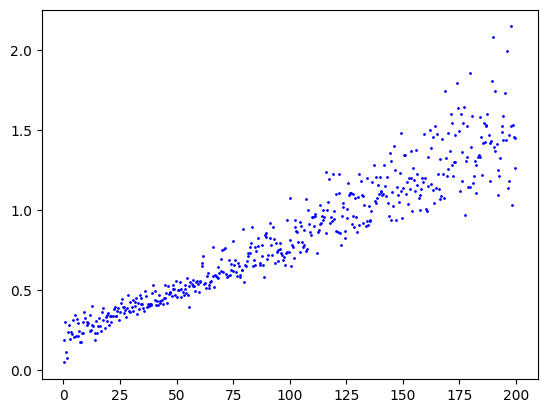

In [84]:
plt.scatter(lhs_dataset["Wv"], Ru_dataset["Ru2"], s=1, color="blue", label="LHS Ru2")

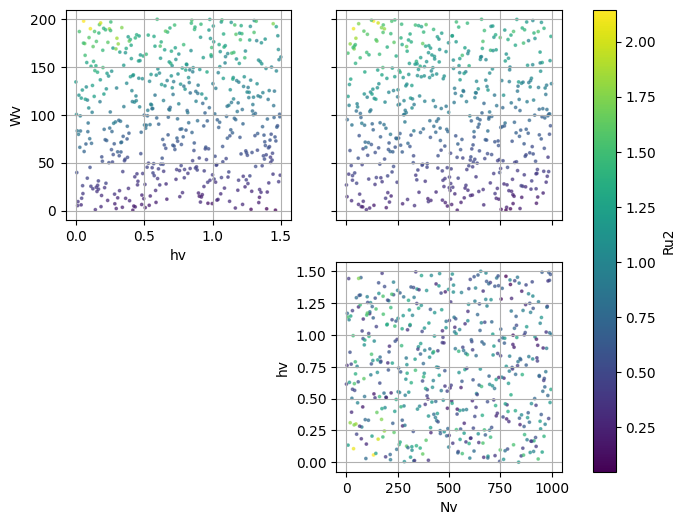

In [85]:
# Select columns Wd, hv, Nv, Hs, Hs_L0, Ru2
fig,axes=plot_scatters_in_triangle(dataframes=[lhs_dataset[["Wv", "hv", "Nv"]]],s=3,data_colors=[Ru_dataset.Ru2.values])#,data_colors=["blue"])
fig.set_size_inches(8, 6)
import matplotlib.cm as cm
import matplotlib.colors as mcolors

vmin=np.nanmin(Ru_dataset.Ru2.values)
vmax=np.nanmax(Ru_dataset.Ru2.values)


# Crear una normalización y un colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.viridis

# Crear el ScalarMappable
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable=sm, ax=axes, label="Ru2", orientation="vertical")